## Loading in and checking the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier


In [35]:
train_data = pd.read_csv("./datasets/train.csv")
len(train_data), train_data.head()

(42000,
    label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
 0       0    ...            0         0         0         0         0   
 1       0    ...            0         0         0         0         0   
 2       0    ...            0         0         0         0         0   
 3       0    ...            0         0         0         0         0   
 4       0    ...            0         0         0         0         0   
 
    pixel779  pixel780  pixel781  pixel782  pixel783  
 0         0         0     

## Splitting the data and its label

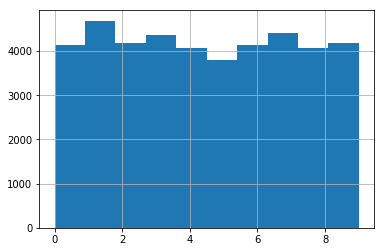

In [3]:
train_label = train_data['label']
train_data = train_data.drop('label', axis=1)
train_label.hist()

(<matplotlib.axes._subplots.AxesSubplot at 0x1219bb128>, 5040)

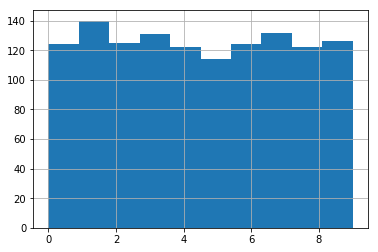

In [5]:
split = StratifiedShuffleSplit(n_splits=1, train_size=.12, test_size=0.03, random_state=0)
for train_index, test_index in split.split(train_data, train_label):
    split_train_data, split_test_data = train_data.loc[train_index], train_data.loc[test_index]
    split_train_label, split_test_label = train_label.loc[train_index], train_label.loc[test_index]
    
split_test_label.hist(), len(split_train_data)

## Checking the image quality of a random value

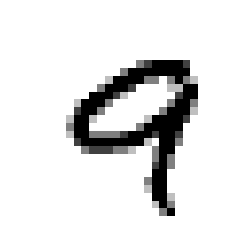

In [6]:
some_digit = split_train_data.values[2000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')

plt.axis('off')
plt.show()


## Normalize data for better preformance

In [7]:
split_train_data = split_train_data / 255.0
split_test_data = split_test_data / 255.0

# Attempting to solve using a KNN Classifier

In [9]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(split_train_data, split_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
knn_clf.predict([some_digit])

array([9])

## Scoring out model using our split testing data

In [26]:
knn_clf.score(split_test_data, split_test_label)

0.9277380952380953

## Tuning model by removing grayscale

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
31170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


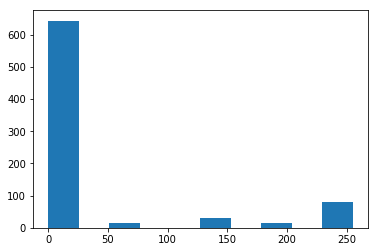

In [107]:
plt.hist(some_digit)
split_train_data.head()

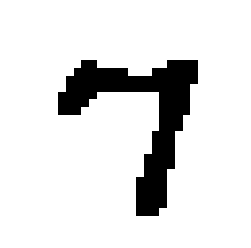

In [11]:
bw_split_test_data = split_test_data.copy()
bw_split_train_data = split_train_data.copy()

bw_split_test_data[bw_split_test_data>0]=1
bw_split_train_data[bw_split_train_data>0]=1

some_digit = bw_split_train_data.values[2000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary)

plt.axis('off')
plt.show()

### Retain classifier using the new black and white data

In [12]:
bw_knn_clf = KNeighborsClassifier(n_jobs=-1)
bw_knn_clf.fit(bw_split_train_data, split_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

## Scoring out model using our split testing data


In [13]:
bw_knn_clf.score(bw_split_test_data, split_test_label)

0.960952380952381

BW holds lower accuracey than allowing for grayscale. even when thinning then umbers with minmax'ing the clip.

## Aiming to improve accurance by adjusting the hyperparams

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(n_neighbors=list(range(1, 32)), weights=['uniform', 'distance'])

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(split_train_data, split_train_label)
grid_search.best_score_, grid_search.best_params_

(0.9436507936507936, {'n_neighbors': 4, 'weights': 'distance'})

### Taking the new hyperparams setup a new Classifier and train on the larger dataset

(<matplotlib.axes._subplots.AxesSubplot at 0x1293f5a58>, 33600)

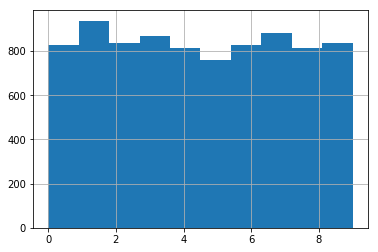

In [10]:
tuned_knn = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(train_data, train_label):
    eighty_split_train_data, twenty_split_test_data = train_data.loc[train_index], train_data.loc[test_index]
    eighty_split_train_label, twenty_split_test_label = train_label.loc[train_index], train_label.loc[test_index]
    
twenty_split_test_label.hist(), len(eighty_split_train_data)

In [11]:
tuned_knn.fit(eighty_split_train_data, eighty_split_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [12]:
tuned_knn.score(twenty_split_test_data, twenty_split_test_label)

0.9702380952380952

### Figuring out what is going wrong

In [40]:
from sklearn.metrics import confusion_matrix

train_label_predict = cross_val_predict(tuned_knn, eighty_split_train_data, eighty_split_train_label, cv=3)
conf_mx = confusion_matrix(eighty_split_train_label, train_label_predict)

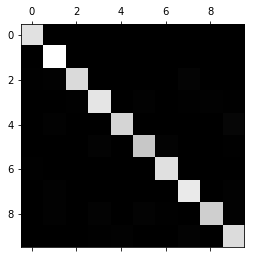

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

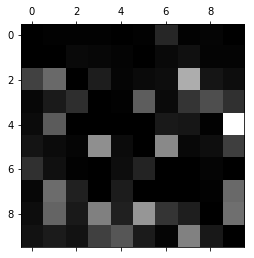

In [50]:
norm_conf_mx = conf_mx / conf_mx.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Adding More Data

We are going to add more data to train on. To do this we have the below augment_images function.

This function is designed to be multiprocessed and will return image and label data over a Pipe.

By default we will change the offset of the image by 3 different settings as well as rotate the image two ways.
Including the original image this will give us 25 images for every 1 image for a total of 1,050,000 images instead of 42,000. 

We run this code in the second block using all avaliable cores of the CPU. on a 2017 MBP this took about 8 hours to complete.

To avoid having to run this again the augment data and labels objects have been exported via numpy.save and can be easily reloaded.

See `aug_data_obj.npy` and `aug_labels_obj.npy` in the datasets folder to skip reruning the code below.

In [511]:
from scipy.ndimage.interpolation import shift, rotate
from tempfile import TemporaryFile

def augment_images(image_data, image_label, send_image_end, send_label_end, offset=[2, 3, 4], rotate_offset=[20,340]):
    image_array = image_data.values
    label_array = image_label.values
    for img_i in range(len(image_data.values)):
        print("Starting:", img_i) if img_i % 1000 == 0 else ""
        image = image_data.values[img_i]
        image = image.reshape(28,28)
        for r in range(len(rotate_offset)):
            image_r = rotate(image, rotate_offset[r], reshape=False)
            for i in range(len(offset)):
                up = shift(image_r, [offset[i], 0]).reshape(1,-1)[0]
                right = shift(image_r, [0, offset[i]]).reshape(1,-1)[0]
                down = shift(image_r, [-offset[i], 0]).reshape(1,-1)[0]
                left = shift(image_r, [0, -offset[i]]).reshape(1,-1)[0]
                image_array = np.vstack((image_array, up, down, left, right))
                
                label_ = image_label.values[img_i]
                label_array = np.append(label_array, [label_, label_, label_, label_])
    
    ifd, ipath = mkstemp()
    ifile = os.fdopen(ifd, 'wb')
    np.save(ifile, image_array)
    ifile.close()
    
    lfd, lpath = mkstemp()
    lfile = os.fdopen(lfd, 'wb')
    np.save(lfile, label_array)
    lfile.close()
    
    send_image_end.send(ipath)
    send_label_end.send(lpath)

In [513]:
import multiprocessing

print('Original sizes of data and labels:', len(train_data.values), len(train_label.values))

image_pipe_list = []
label_pipe_list = []
jobs = []
max_processors = os.cpu_count()
label_chunk = np.split(train_label, max_processors)
data_chunk = np.split(train_data, max_processors)
for i in range(len(data_chunk)):
    recv_image_end, send_image_end = multiprocessing.Pipe(False)
    recv_label_end, send_label_end = multiprocessing.Pipe(False)
    
    p = Process(target=augment_images, args=(data_chunk[i], label_chunk[i], send_image_end, send_label_end))
    image_pipe_list.append(recv_image_end)
    label_pipe_list.append(recv_label_end)
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()

image_path_list = [x.recv() for x in image_pipe_list]
_images_array = []
for path in image_path_list:
    fd = open(path, mode='rb')
    _images_array = np.vstack((_images_array, np.load(fd))) if len(_images_array)> 0 else np.load(fd)
    fd.close()
    os.remove(path)
aug_data = pd.DataFrame(_images_array)

label_path_list = [x.recv() for x in label_pipe_list]
_labels_array = []
for path in label_path_list:
    fd = open(path, mode='rb')
    _labels_array = np.append((_labels_array), np.load(fd)) if len(_labels_array) > 0 else np.load(fd)
    fd.close()
    os.remove(path)
aug_label = _labels_array
print('Augemented sizes of data and labels:', len(aug_data.values), len(aug_label.values))

Original sizes of data and labels: 42000 42000
Starting: 0
Starting: 0
Starting: 0
Starting: 0
Starting: 0
Starting: 0
Starting: 0
Starting: 0
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 1000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 2000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 3000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 4000
Starting: 5000
Starting: 5000
Starting: 5000
Starting: 5000
Starting: 5000
Starting: 5000
Starting: 5000
Starting: 5000
Augemented sizes of data and labels: 1050000 1050000


In [514]:
np.save('./datasets/aug_data_obj', aug_data)
np.save('./datasets/aug_labels_obj', aug_label)

In [3]:
aug_data = np.load('./datasets/aug_data_obj.npy')
aug_label = np.load('./datasets/aug_labels_obj.npy')

In [4]:
aug_data = pd.DataFrame(aug_data)
aug_label = pd.DataFrame(aug_label)

In [4]:
len(aug_data)

1050000

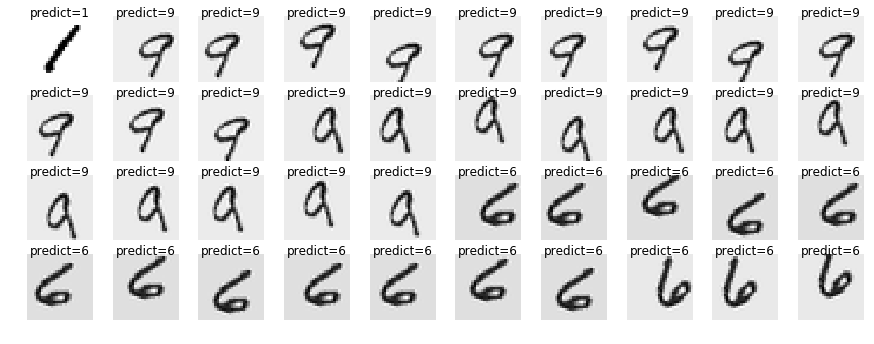

In [4]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(aug_data.values[-i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % aug_label.values[-i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

### Clean up the noise that the augmenting made

(array([ 21., 610.,  21.,  17.,  13.,  15.,  10.,  15.,  47.,  15.]),
 array([-43. ,  -8.8,  25.4,  59.6,  93.8, 128. , 162.2, 196.4, 230.6,
        264.8, 299. ]),
 <a list of 10 Patch objects>)

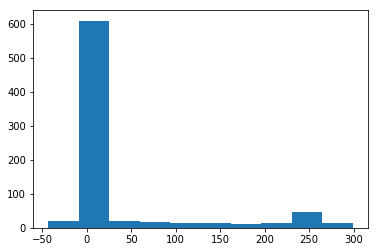

In [5]:
aug_data.head()
plt.hist(aug_data.iloc[-36])

In [5]:
no_subzero_aug = aug_data.copy()
aug_data = None
no_subzero_aug[no_subzero_aug<0] = 0

(array([635.,  17.,  16.,  12.,  12.,   6.,  15.,  22.,  37.,  12.]),
 array([  0. ,  29.9,  59.8,  89.7, 119.6, 149.5, 179.4, 209.3, 239.2,
        269.1, 299. ]),
 <a list of 10 Patch objects>)

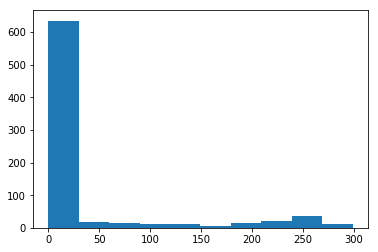

In [7]:
no_subzero_aug.head()
plt.hist(no_subzero_aug.iloc[-36])

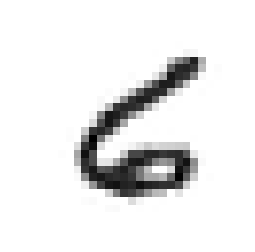

In [8]:
test_img = no_subzero_aug.iloc[-36]
plt.imshow(test_img.values.reshape((28,28)), cmap=plt.cm.binary)
plt.axis('off')
plt.show()

In [6]:
no_subzero_aug = no_subzero_aug / 255.0

In [7]:
import gc
gc.collect()

11

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19b50668>]],
       dtype=object), 210000, 4200)

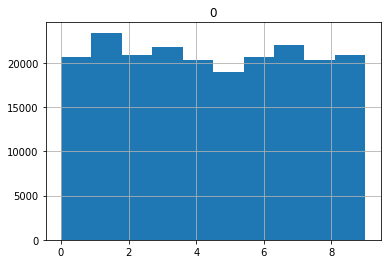

In [15]:
split = StratifiedShuffleSplit(n_splits=1, train_size=0.2, test_size=0.004, random_state=0)
for train_index, test_index in split.split(no_subzero_aug, aug_label):
    aug_split_train_data, aug_split_test_data = no_subzero_aug.loc[train_index], no_subzero_aug.loc[test_index]
    aug_split_train_label, aug_split_test_label = aug_label.loc[train_index], aug_label.loc[test_index]
    
aug_label = None
no_subzero_aug = None
gc.collect()
    
aug_split_train_label.hist(), len(aug_split_train_data), len(aug_split_test_data)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(n_neighbors=np.arange(3,15), weights=['uniform', 'distance'])

knn = KNeighborsClassifier(n_jobs=2)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=3)
grid_search.fit(aug_split_train_data, np.ravel(aug_split_train_label))
grid_search.best_score_, grid_search.best_params_

KeyboardInterrupt: 

In [ ]:
grid_search = None
knn = None
gc.collect()

In [32]:
aug_knn_clf = KNeighborsClassifier(n_neighbors=1, weights='distance', n_jobs=6)
aug_knn_clf.fit(aug_split_train_data, np.ravel(aug_split_train_label))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=6, n_neighbors=1, p=2,
           weights='distance')

In [12]:
# Clear unneeded data for memory reasons
aug_split_train_data = None
aug_split_train_label = None
gc.collect()

In [33]:
aug_knn_clf.score(aug_split_test_data, np.ravel(aug_split_test_label))

0.9552380952380952

Best we got with a large training set was around ~96% using the KNN when using Kaggle's test set.

## Pulling in our test data

In [18]:
test_data_final = pd.read_csv("./datasets/test.csv")
test_data = test_data / 255.0
results = aug_knn_clf.predict(test_data)

(array([2828., 3437., 2641., 2795., 2683., 2510., 2793., 3028., 2485.,
        2800.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

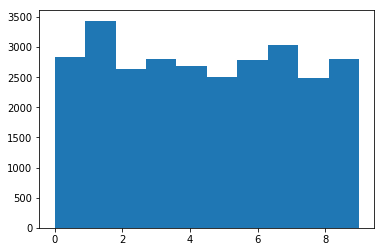

In [19]:
plt.hist(results)

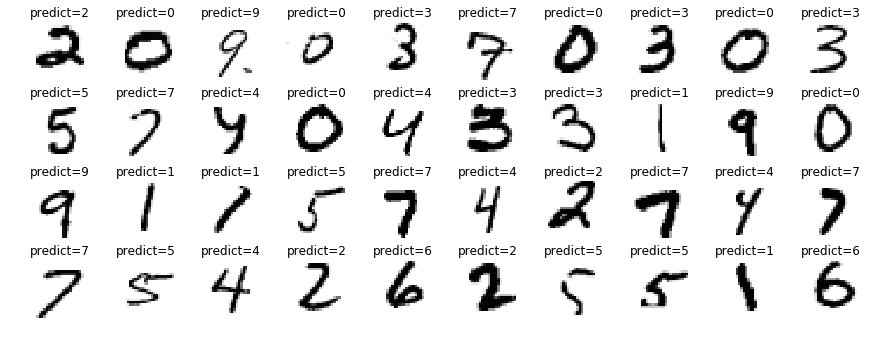

In [20]:
# Preview predictions
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_data.values[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [21]:
# Exporting our results for Kaggle
df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('./datasets/results.csv', header=True)